** Import des bibliothèques

In [11]:
# === Import des librairies principales ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


** Chargement du dataset

In [12]:
import os

DATA_FILENAME = "dataset-diabete.csv"

# Charger le fichier
df = pd.read_csv( DATA_FILENAME)

# Aperçu
print("Dimensions :", df.shape)
df.head()

Dimensions : (768, 9)


,Unnamed: 0,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0,6,148,72,35,0,33.6,0.627,50
1,1,1,85,66,29,0,26.6,0.351,31
2,2,8,183,64,0,0,23.3,0.672,32
3,3,1,89,66,23,94,28.1,0.167,21
4,4,0,137,40,35,168,43.1,2.288,33


** Exploration basique

In [13]:
# === Exploration du jeu de données ===
print("Types de données :\n", df.dtypes)
print("\nValeurs manquantes par colonne :\n", df.isna().sum())
print("\nDoublons :", df.duplicated().sum())

# Aperçu statistique
df.describe().T


Types de données :
 Unnamed: 0                    int64
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
dtype: object

Valeurs manquantes par colonne :
 Unnamed: 0                  0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Doublons : 0


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,768.0,383.500000,221.846794,0.000,191.75000,383.5000,575.25000,767.00
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


** gestion des valeurs manquantes avec knn 

In [14]:
# === Remplacement des 0 par NaN pour les colonnes concernées ===

# Liste des colonnes où 0 = valeur manquante
cols_with_zero_as_missing = [
    'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'
]

# Remplacer 0 par NaN uniquement dans ces colonnes
df[cols_with_zero_as_missing] = df[cols_with_zero_as_missing].replace(0, np.nan)

# Vérifions le nombre de valeurs manquantes après remplacement
print("Valeurs manquantes après remplacement des 0 :")
print(df[cols_with_zero_as_missing].isna().sum())


Valeurs manquantes après remplacement des 0 :
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


** remplace les NAN avec KNN

In [17]:
from sklearn.impute import KNNImputer

# Création de l'imputer (k=5 voisins est souvent un bon point de départ)
imputer = KNNImputer(n_neighbors=5)

# Application du KNN Imputer sur tout le dataset numérique
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Vérification rapide
df_imputed.isna().sum()




Unnamed: 0                  0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

** Visualisation rapide

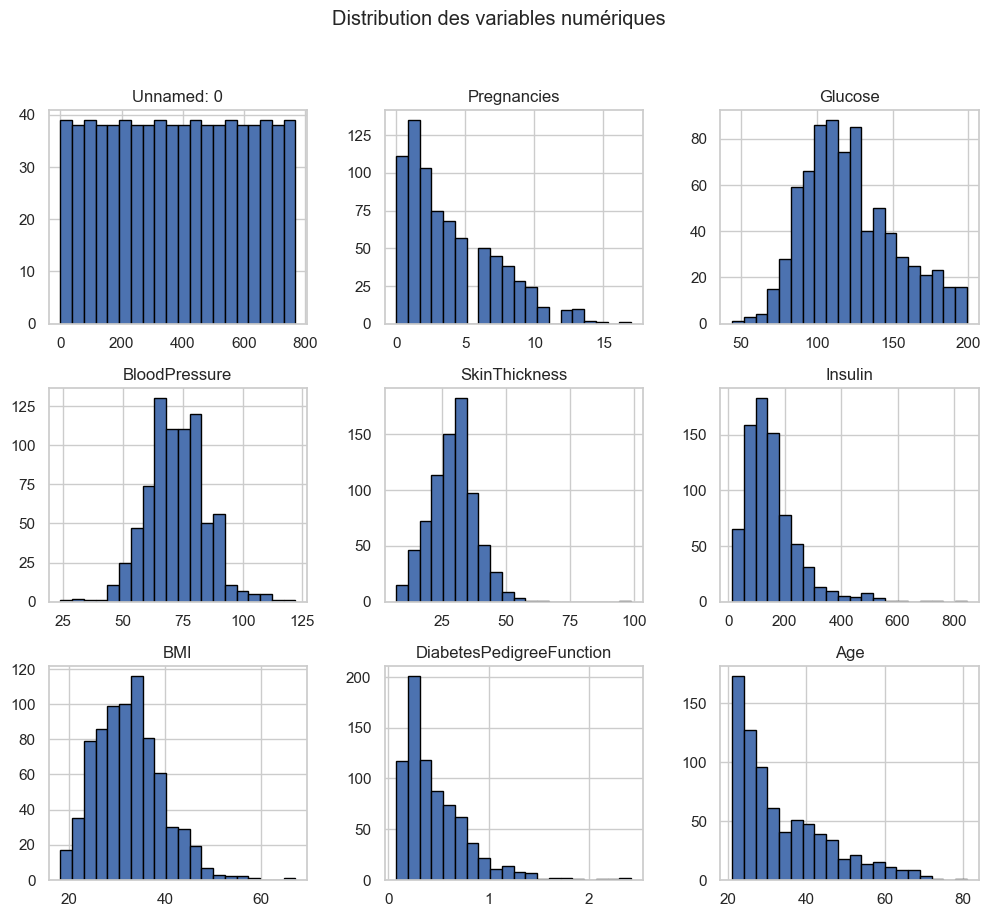

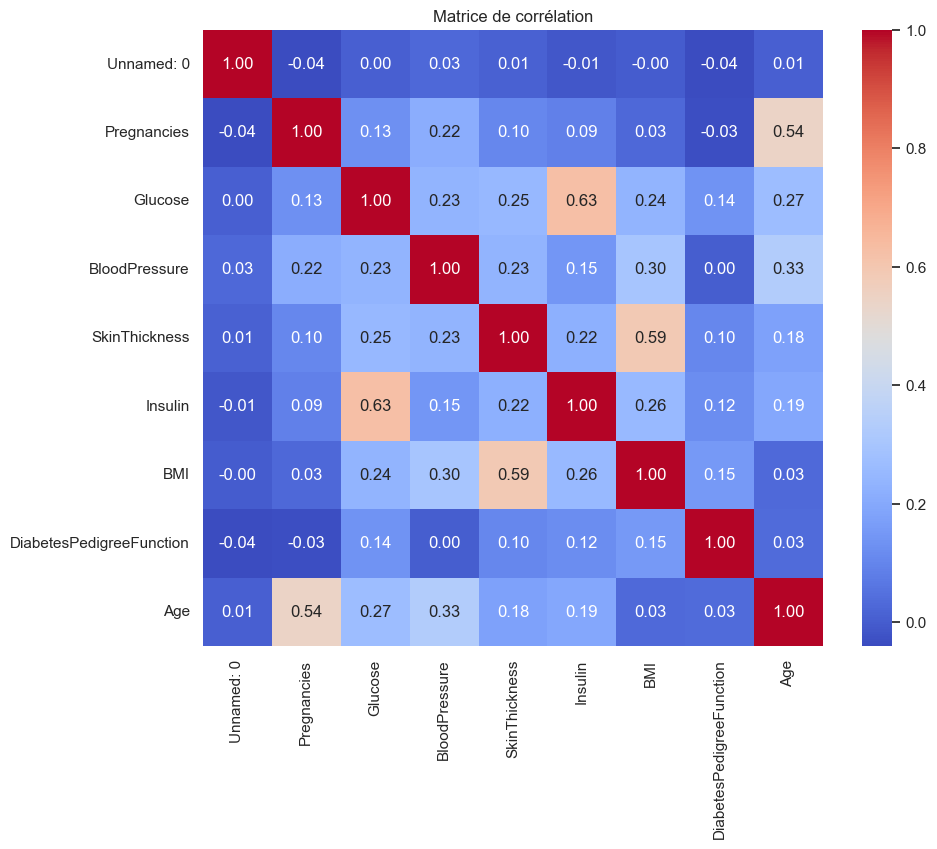

In [18]:
# === Distribution des variables numériques ===
numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()

# Histogrammes
df_imputed[numeric_cols].hist(bins=20, figsize=(12, 10), edgecolor='black')
plt.suptitle("Distribution des variables numériques")
plt.show()

# Matrice de corrélation
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()


** les outliers

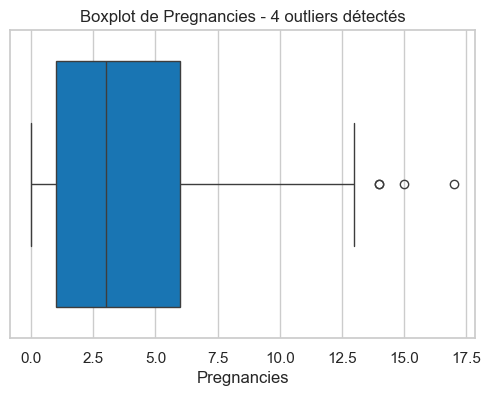

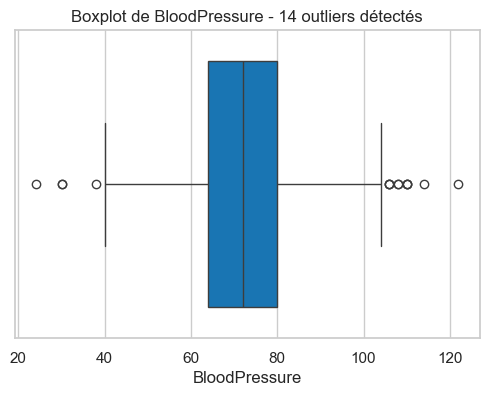

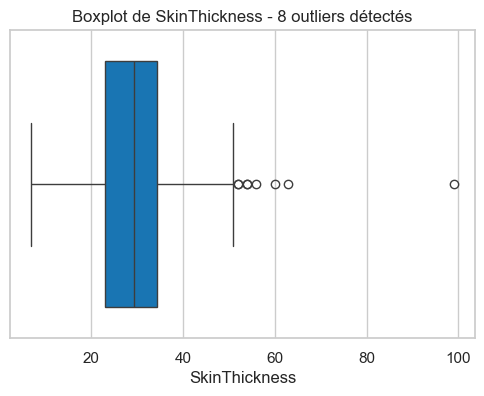

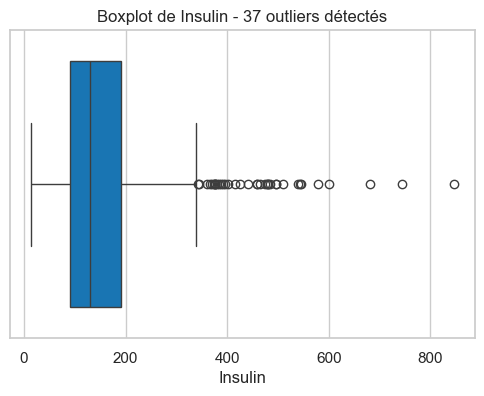

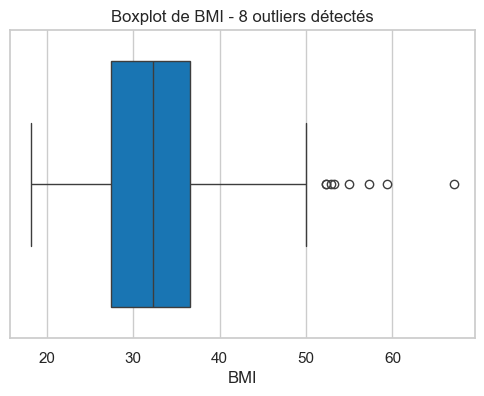

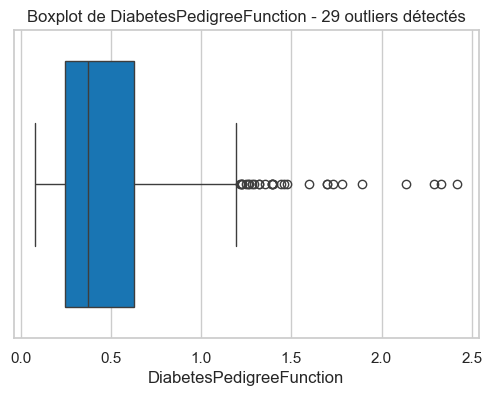

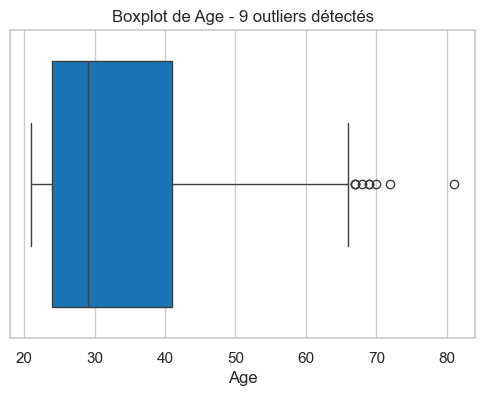


Résumé du nombre d'outliers par variable :
Unnamed: 0: 0
Pregnancies: 4
Glucose: 0
BloodPressure: 14
SkinThickness: 8
Insulin: 37
BMI: 8
DiabetesPedigreeFunction: 29
Age: 9


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# On travaille sur le DataFrame imputé
numerical_cols = df_imputed.select_dtypes(include=['int64', 'float64']).columns

# Fonction pour détecter les outliers avec IQR
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers

# Visualisation + comptage
outlier_summary = {}

for col in numerical_cols:
    outliers = detect_outliers_iqr(df_imputed, col)
    n_outliers = len(outliers)
    outlier_summary[col] = n_outliers
    
    if n_outliers > 0:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=df_imputed[col], color="#007ACC")
        plt.title(f"Boxplot de {col} - {n_outliers} outliers détectés")
        plt.show()

# Résumé global
print("\nRésumé du nombre d'outliers par variable :")
for col, n in outlier_summary.items():
    print(f"{col}: {n}")


**  winsorize des outliers

In [25]:
import pandas as pd
from scipy.stats.mstats import winsorize

# Copier le DataFrame après imputation
df_clean = df_imputed.copy()

# Colonnes numériques à gérer
cols_outliers = ['BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Appliquer Winsorization
for col in cols_outliers:
    # Remplacer les valeurs inférieures au 1er percentile et supérieures au 99e percentile
    df_clean[col] = winsorize(df_clean[col], limits=(0.01, 0.01)).data

# Vérifier les valeurs modifiées
for col in cols_outliers:
    modified = df_imputed[col] != df_clean[col]
    print(f"\n{col} - valeurs modifiées ({modified.sum()} valeurs) :")
    print(df_clean[modified][col].values)



BloodPressure - valeurs modifiées (12 valeurs) :
[ 44.  44. 106. 106. 106.  44. 106. 106. 106.  44.  44. 106.]

SkinThickness - valeurs modifiées (10 valeurs) :
[52. 52. 52. 52. 10. 10. 10. 52. 10. 52.]

Insulin - valeurs modifiées (13 valeurs) :
[540. 540.  23. 540. 540. 540. 540.  23.  23. 540.  23.  23.  23.]

BMI - valeurs modifiées (13 valeurs) :
[19.5 19.5 52.3 52.3 52.3 19.5 52.3 19.5 19.5 19.5 52.3 19.5 52.3]

DiabetesPedigreeFunction - valeurs modifiées (14 valeurs) :
[1.699 1.699 1.699 0.092 0.092 0.092 1.699 0.092 0.092 1.699 1.699 1.699
 0.092 0.092]

Age - valeurs modifiées (6 valeurs) :
[67. 67. 67. 67. 67. 67.]


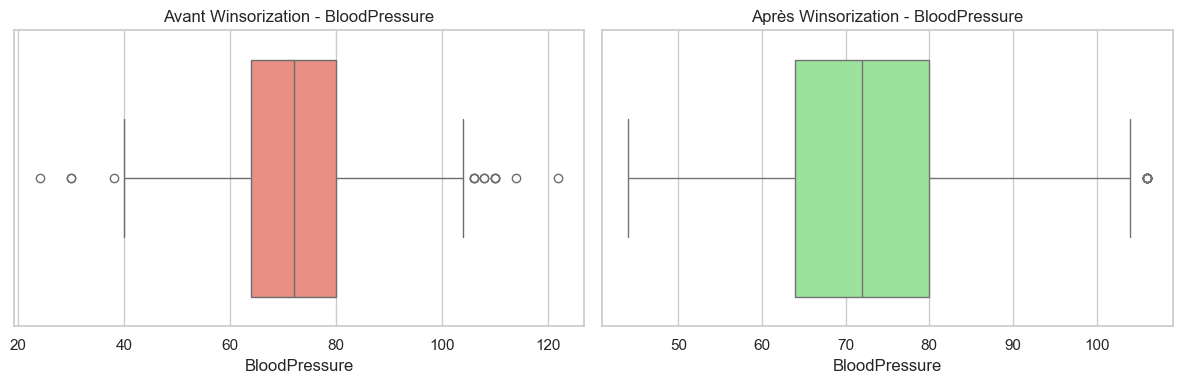

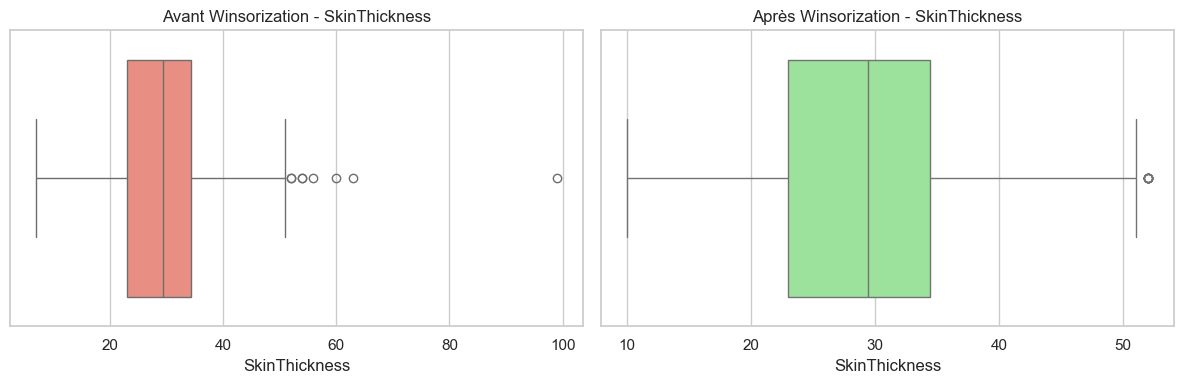

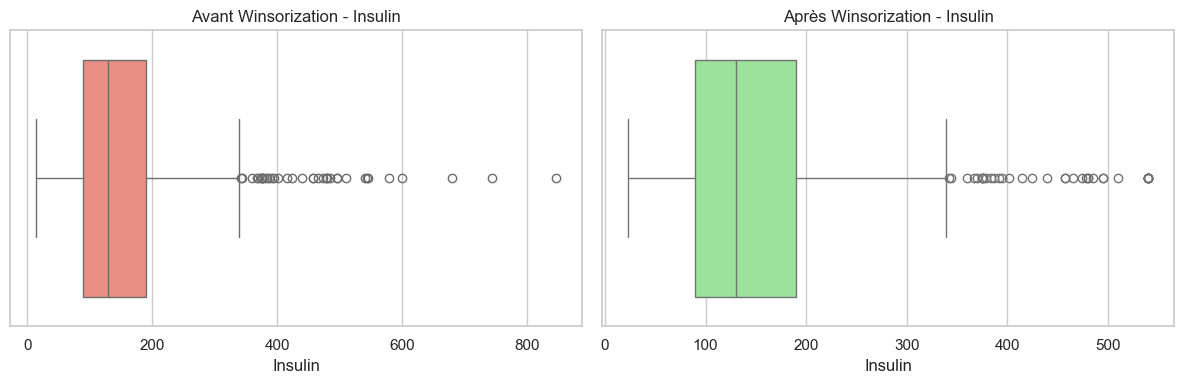

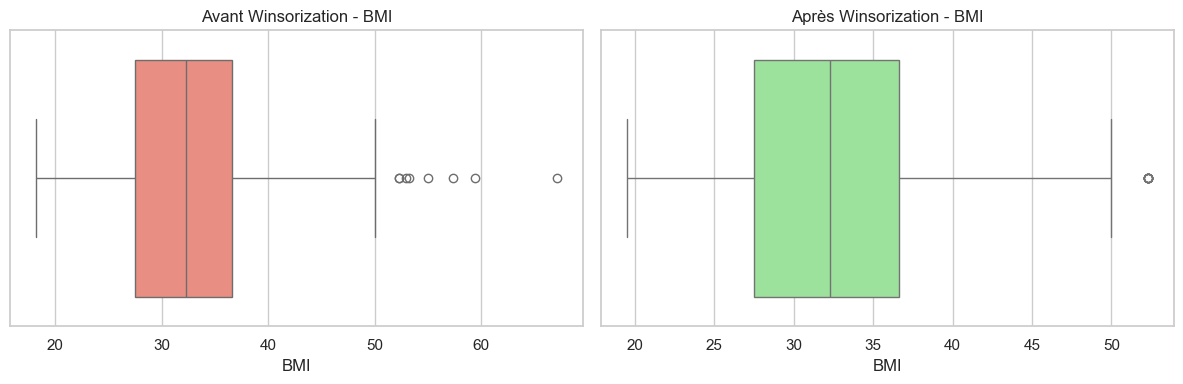

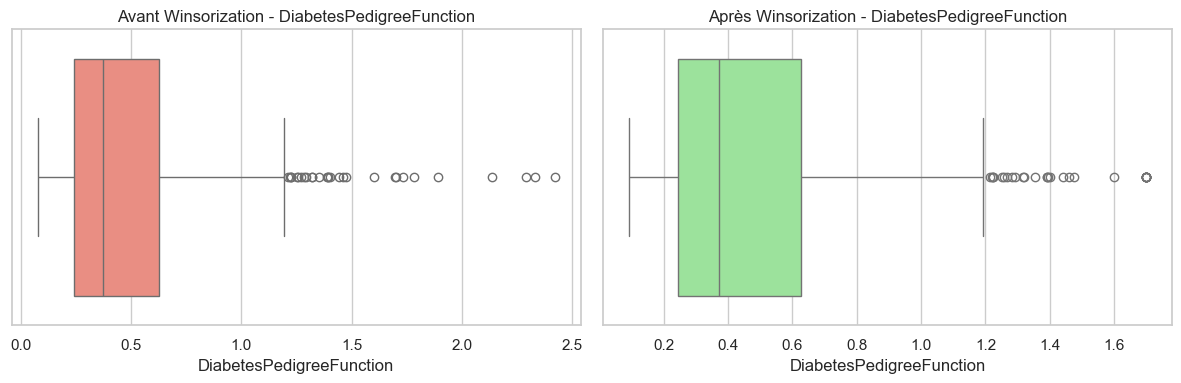

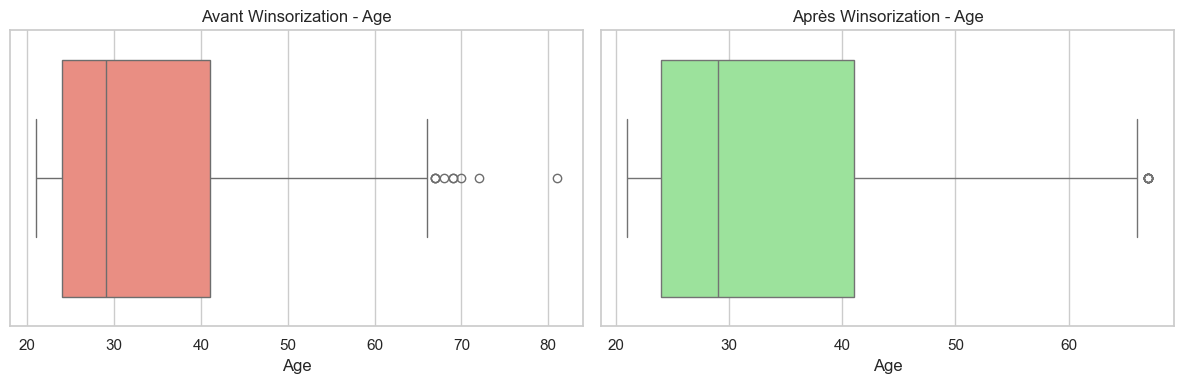

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in cols_outliers:
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    sns.boxplot(x=df_imputed[col], ax=axes[0], color='salmon')
    axes[0].set_title(f"Avant Winsorization - {col}")
    sns.boxplot(x=df_clean[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f"Après Winsorization - {col}")
    plt.tight_layout()
    plt.show()


avec winsorisation il y a tjr des outliers donc on utlise clipping   :

Détection des outliers avec la méthode IQR.
Application d’une Winsorization légère (1%) pour les valeurs extrêmes.
Application d’un clipping basé sur IQR pour toutes les valeurs encore considérées comme outliers après Winsorization.
Affichage visuel avant/après pour chaque colonne.

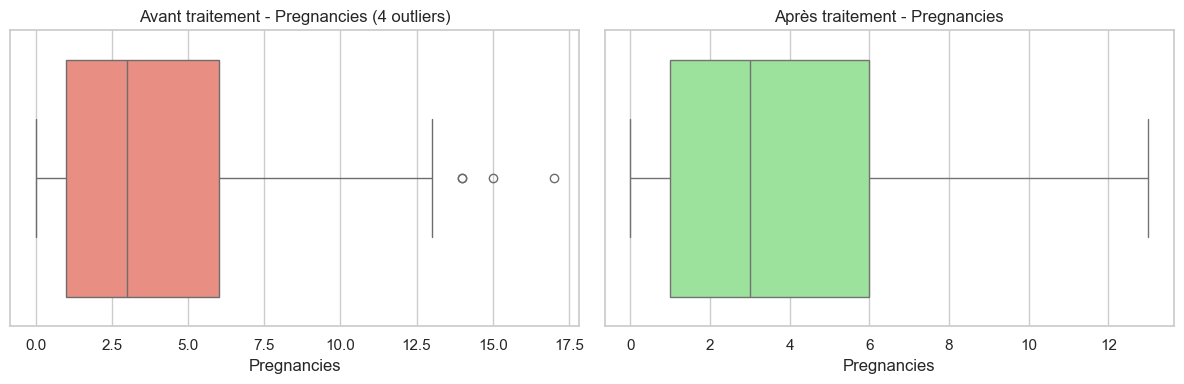

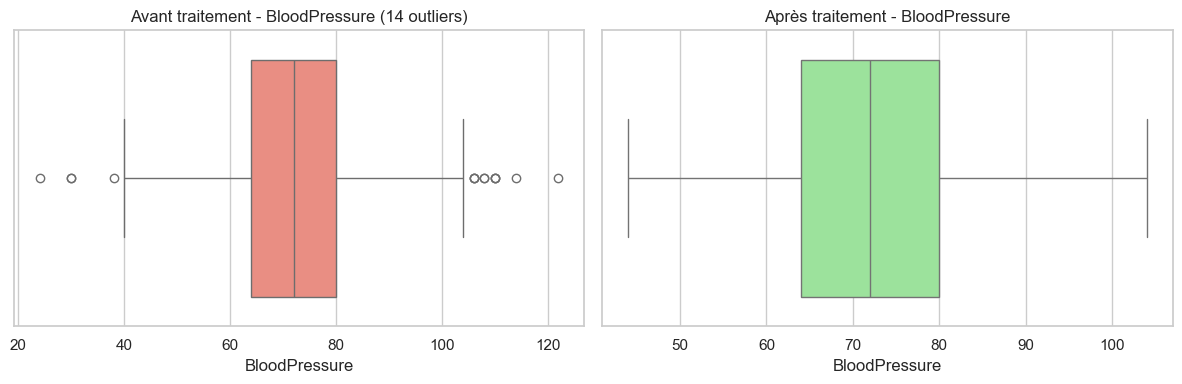

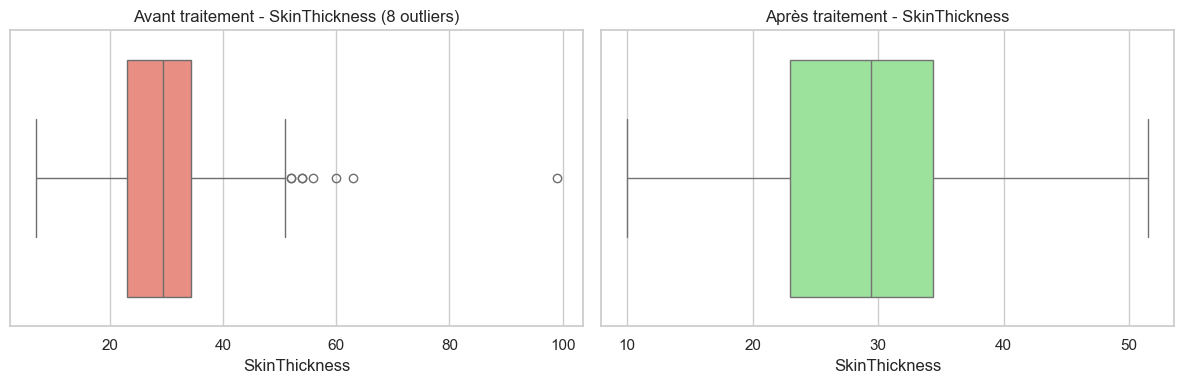

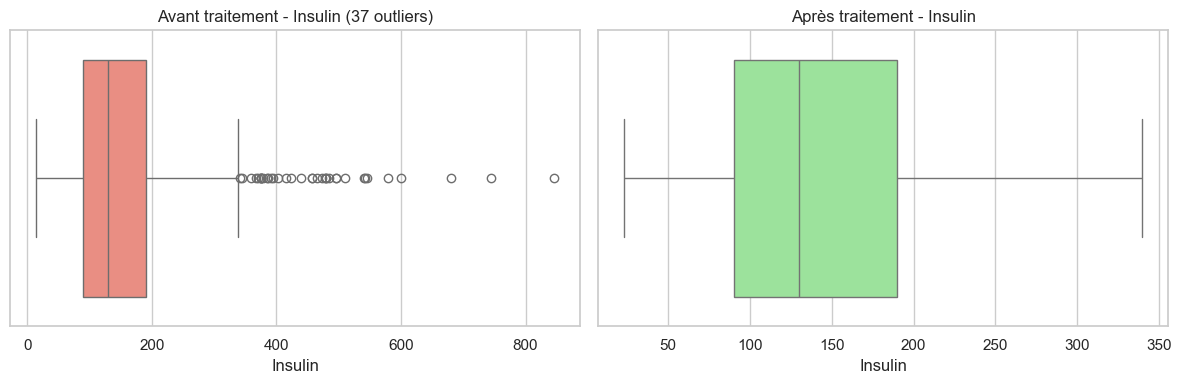

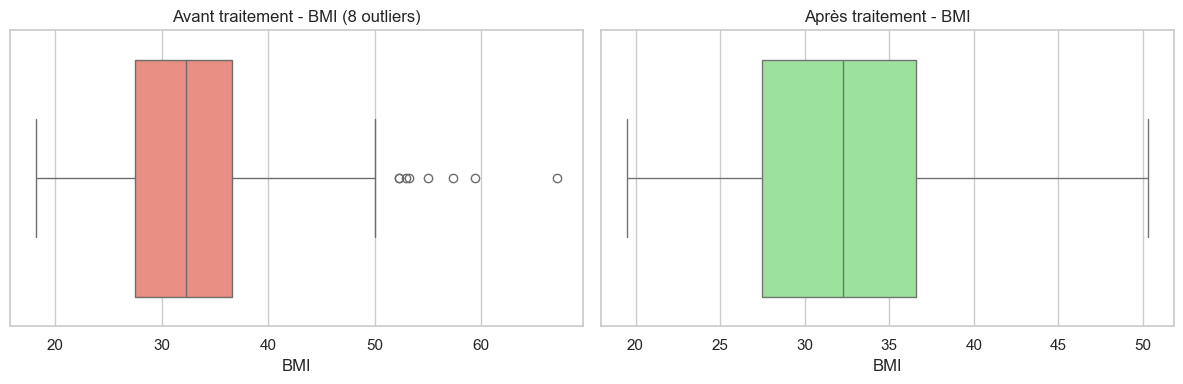

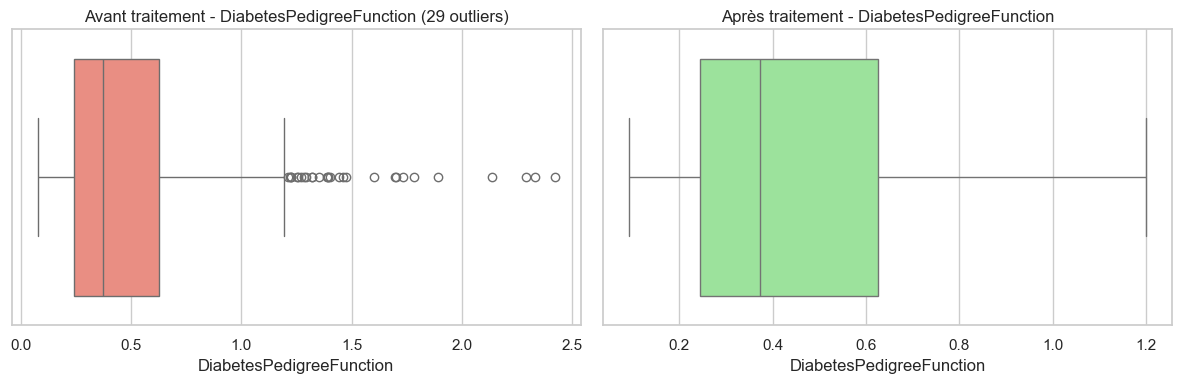

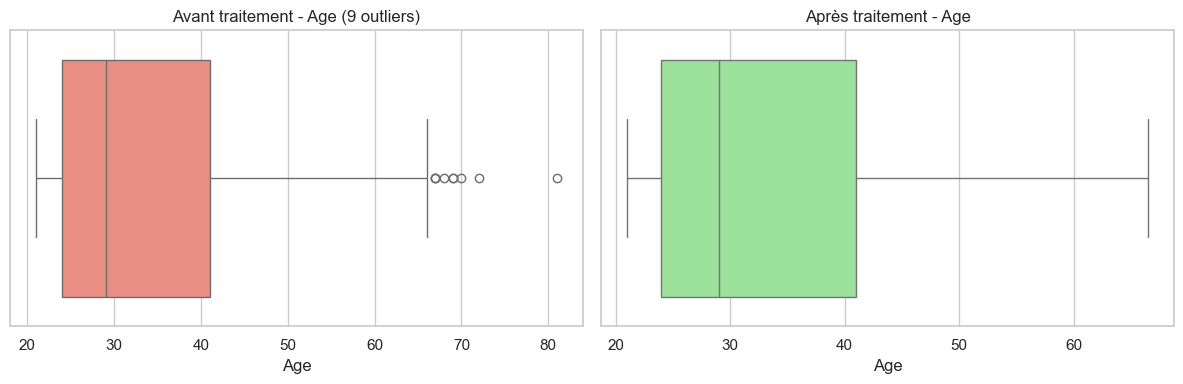

In [29]:
import pandas as pd
from scipy.stats.mstats import winsorize
import seaborn as sns
import matplotlib.pyplot as plt

# Copier le DataFrame après imputation
df_clean = df_imputed.copy()

# Colonnes numériques
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Détection des outliers avec IQR
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Gestion des outliers : Winsorize + Clipping IQR
for col in numerical_cols:
    outliers, lower, upper = detect_outliers_iqr(df_clean, col)
    n_outliers = len(outliers)
    
    if n_outliers > 0:
        # 1️⃣ Winsorization légère (1%)
        df_clean[col] = winsorize(df_clean[col], limits=(0.01, 0.01)).data
        
        # 2️⃣ Re-calcul des bornes IQR après Winsorization
        _, lower, upper = detect_outliers_iqr(df_clean, col)
        
        # 3️⃣ Clipping basé sur IQR pour éliminer les outliers restants
        df_clean[col] = df_clean[col].clip(lower, upper)
        
        # 4️⃣ Affichage visuel avant/après
        fig, axes = plt.subplots(1,2, figsize=(12,4))
        sns.boxplot(x=df_imputed[col], ax=axes[0], color='salmon')
        axes[0].set_title(f"Avant traitement - {col} ({n_outliers} outliers)")
        sns.boxplot(x=df_clean[col], ax=axes[1], color='lightgreen')
        axes[1].set_title(f"Après traitement - {col}")
        plt.tight_layout()
        plt.show()


** relation entre variable 

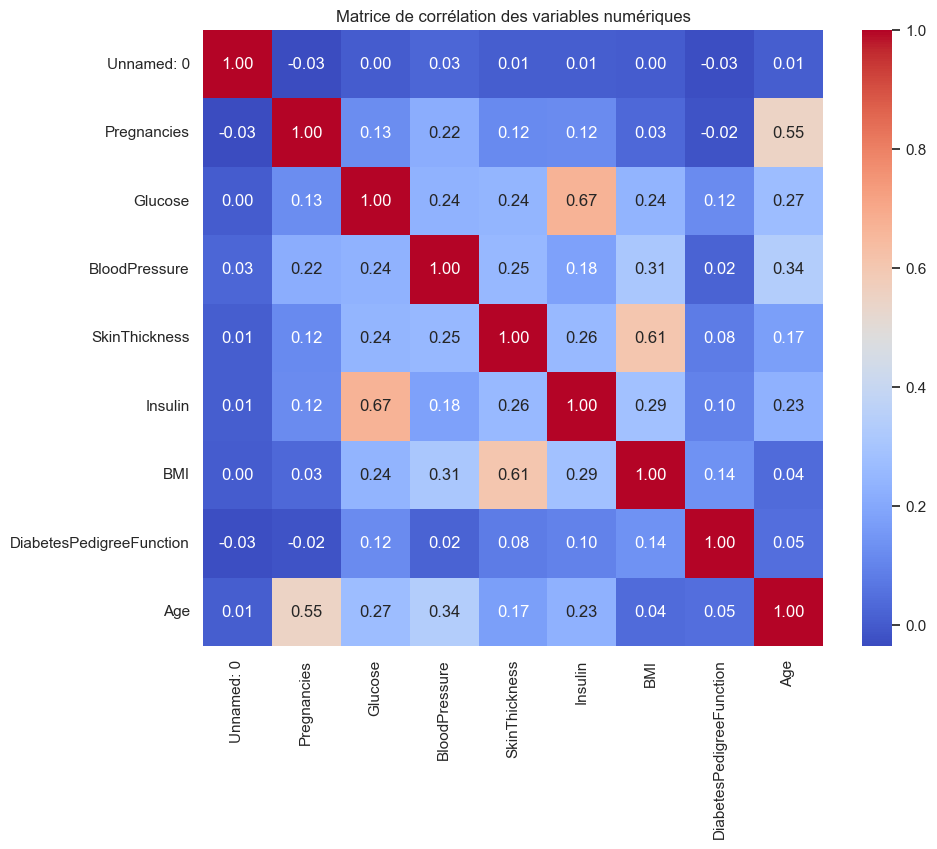

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des colonnes numériques
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Matrice de corrélation
corr_matrix = df_clean[numerical_cols].corr()

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques")
plt.show()
